In [20]:

#Tute: https://colab.research.google.com/drive/10ZrZaLBmhEqKSSEoe_cos783m2junUdr?usp=sharing#scrollTo=Bdqu_tJFBD_c
    
import os
import pandas as pd
import numpy as np
import pickle
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
import ftfy
from gensim.models.fasttext import FastText
#!pip install rank_bm25 --quiet #install BM25
#!pip install --no-binary :all: nmslib #install nmslib
from rank_bm25 import BM25Okapi
import nmslib
import time
#spacy.util.set_data_path('/Users/stuartvandegiessen/opt/anaconda3/envs/invest/lib/python3.8/site-packages')
import en_core_web_sm


In [44]:
import copy
def load_n_explode(file_res="API_results_" + time.strftime("%Y%m%d") + ".csv"):
    # file_res = "API_results_20210823.csv"
    my_df = pd.read_csv(file_res,error_bad_lines=False)

    ## Categories
    # my_df["Categories"]
    # Willnjust keep 2 levels.
    my_df["Categories"] = my_df["Categories"].map(eval, na_action='ignore')
    new_df = my_df["Categories"].apply(pd.Series)
    my_df["Categories"] = new_df[0].apply(pd.Series).UrlFriendlyName
    my_df["Sub_Categories"] = new_df[1].apply(pd.Series).UrlFriendlyName

    ###********NEW> LIMIT TO WINES ONLY
    my_df = my_df[my_df['Categories'].isin(['red-wine', 'white-wine'])]
    
    ## Reviews
    my_df["Reviews"] = my_df["Reviews"].map(eval, na_action='ignore')
    # Try with first 2 reviews
    new_df = my_df["Reviews"].apply(pd.Series)
    # First
    my_df["Review1_auth"] = new_df[0].apply(pd.Series).author.apply(pd.Series).Value
    my_df["Review1_authorcontent"] = new_df[0].apply(pd.Series).authorcontent.apply(pd.Series).Value
    my_df["Review1_points"] = new_df[0].apply(pd.Series).points.apply(pd.Series).Value
    my_df["Review1_source"] = new_df[0].apply(pd.Series).source.apply(pd.Series).Value
    my_df["Review1_text"] = new_df[0].apply(pd.Series).text.apply(pd.Series).Value
    my_df["Review1_vintage"] = new_df[0].apply(pd.Series).vintage.apply(pd.Series).Value
    # Second
    my_df["Review2_auth"] = new_df[1].apply(pd.Series).author.apply(pd.Series).Value
    my_df["Review2_authorcontent"] = new_df[1].apply(pd.Series).authorcontent.apply(pd.Series).Value
    my_df["Review2_points"] = new_df[1].apply(pd.Series).points.apply(pd.Series).Value
    my_df["Review2_source"] = new_df[1].apply(pd.Series).source.apply(pd.Series).Value
    my_df["Review2_text"] = new_df[1].apply(pd.Series).text.apply(pd.Series).Value
    my_df["Review2_vintage"] = new_df[1].apply(pd.Series).vintage.apply(pd.Series).Value

    # Illl make a deep copy for later
    full_df = copy.deepcopy(my_df)
    # full_df = full_df

    # Additional details
    my_df["AdditionalDetails"] = my_df["AdditionalDetails"].map(eval, na_action='ignore')
    # Can't use nested lists of JSON objects in pd.json_normalize
    my_df = my_df.explode(column="AdditionalDetails").reset_index(drop=True)

    # Hacky, but it works... so we wont be touching this stuff!
    add_df = pd.DataFrame(pd.json_normalize(my_df["AdditionalDetails"]))
    del add_df["DisplayName"]
    df = pd.concat([my_df, add_df], axis=1)
    df = df.pivot(index='Stockcode', columns='Name', values='Value').reset_index().drop_duplicates(subset=['Stockcode'],
                                                                                                   keep=False)

    # Check point, and also a way to get rid of headers
    newdf = pd.merge(full_df, df, on='Stockcode')
    newdf["Mystery"] = newdf["Description"].str.contains("Wraps")
    # This is an old secret seleciton one. Only two, so will drop them
    newdf = newdf[~newdf["Description"].str.contains("Secret Selection")]
    newdf = newdf[~newdf["Stockcode"].str.contains("672366")]
    # newdf = newdf.drop_duplicates(subset=['Stockcode'], keep=False)
    return newdf



## Load our data

In [45]:
 my_df = pd.read_csv("API_results_20210903.csv")

/home/stu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (101,106) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:

wide = load_n_explode("API_results_20210903.csv")

/home/stu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (101,106) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [91]:
wide[wide["Stockcode"] == "ER_1000004375_CALSG16"]["webproductname"].notna()

17228    False
Name: webproductname, dtype: bool

In [92]:
wide.to_csv("LATEST.csv")

#input_file = "API_results_" + time.strftime("%Y%m%d") + ".csv"
input_file = "API_results_20210830.csv"
wide = load_n_explode(input_file)

In [89]:

def giveaway(df):
    gives = df.copy(deep=True)
    gives = gives[['Stockcode','Description','webproductname','Prices.singleprice.Value','Prices.promoprice.Value','Prices.promoprice.BeforePromotion','Prices.promoprice.AfterPromotion','IsForDelivery']]
    gives = gives[gives.webproductname.notnull()]
    gives = gives[gives.webproductname.notna()]
    gives = gives[gives["Description"].str.lower().str.contains("wraps")]
    gives = gives[~gives["webproductname"].str.lower().str.contains("wraps")]
    gives = gives[gives["IsForDelivery"]]
    gives["METHOD"] = "giveaway"
    return gives

In [90]:
giveaway(wide)

,Stockcode,Description,webproductname,Prices.singleprice.Value,Prices.promoprice.Value,Prices.promoprice.BeforePromotion,Prices.promoprice.AfterPromotion,IsForDelivery,METHOD
5840,MYSTERY594,Under Wraps Heathcote Shiraz<br>Cabernet 2017...,Feathered Friends Heathcote Shiraz Cabernet 2015,25.00,89.0,150.00,89.0,True,giveaway
9314,MYSTERY424,Under Wraps Adelaide Hills<br>Pinot Noir 2017...,Riposte The Sabre Pinot Noir,29.99,16.9,29.99,16.9,True,giveaway
11627,MYSTERY437,Under Wraps Western<br>Australia Cabernet... ...,Alkoomi Blackbutt Cabernet Merlot Cabernet Franc,59.99,30.0,59.99,30.0,True,giveaway
12870,MYSTERY220,Under Wraps Barossa Valley<br>Shiraz 2016 750mL,Chris Ringland The Maker Edition Shiraz 2016,30.00,NaN,NaN,NaN,True,giveaway
14804,MYSTERY378,Under Wraps Western<br>Australia Cabernet... ...,Peos Estate Cab Sauv,22.99,15.0,22.99,15.0,True,giveaway
17193,MYSTERY459,Under Wraps Great Southern<br>Cabernet Sauvig...,Forest Hill Block 5 Caberent Sauvignon,30.00,NaN,NaN,NaN,True,giveaway
20089,MYSTERY540,Under Wraps Clare Valley<br>Cabernet Sauvigno...,Jim Barry The Benbournie Cabernet Sauvignon 2014,35.88,NaN,NaN,NaN,True,giveaway
20428,MYSTERY411,Under Wraps Hawkes Bay Syrah<br>2010 750mL,Craggy Range Le Sol Syrah 2010,155.99,79.9,155.99,79.9,True,giveaway
20665,MYSTERY242,Under Wraps Barossa Merlot<br>2017 750mL,Gibson My Darling Merlot 2014,24.99,14.9,24.99,14.9,True,giveaway
21016,MYSTERY196,Under Wraps Yarra Valley<br>Chardonnay 2018 ...,Yarra Trail Yarra Valley Chardonnay 2016,31.99,15.0,31.99,15.0,True,giveaway


In [93]:
df1 = wide[wide["Mystery"]]
df2 = wide[~wide["Mystery"]]

,Unnamed: 0,RecommendedProducts,ProductsInSameOffer,Categories,BackorderMessage,Reviews,DeliveryOptionsInfo,SavedLists,Stockcode,Description,...,webstateoforigin,webtitle,webtotalreviewcount,webvideourl,webvintagecurrent,webvintagenote,webwinebody,webwinemaker,webwinestyle,Mystery
0,0,NaN,NaN,red-wine,Limited stock,NaN,NaN,NaN,133780,Dalwhinnie Moonambel<br>Cabernet Sauvignon......,...,Victoria,Moonambel Cabernet Sauvignon,NaN,NaN,2016*,* Vintages may vary from store to store and wh...,Full Bodied,NaN,Dry,False
1,0,NaN,NaN,white-wine,Limited stock,NaN,NaN,NaN,334645,Gossips Sweet Lips Moscato 750mL,...,NaN,Sweet Lips Moscato,166,NaN,NaN,* Vintages may vary from store to store and wh...,Light Bodied,NaN,Semi Sweet,False
2,0,NaN,NaN,red-wine,Limited stock,NaN,NaN,NaN,800109,Wendouree Shiraz 1997 750mL,...,South Australia,Shiraz 1997,NaN,NaN,1997*,NaN,Full Bodied,NaN,Dry,False
3,0,NaN,NaN,red-wine,Limited stock,NaN,NaN,NaN,342393,Château Mouton Rothschild<br>Pauillac 1970 7...,...,NaN,Pauillac 1970,NaN,NaN,1970,NaN,NaN,NaN,Dry,False
4,0,NaN,NaN,red-wine,Limited stock,"[{'text': {'DisplayName': 'WebReviewText1', 'V...",NaN,NaN,324024,Tahbilk Cabernet Sauvignon<br>2005 750mL,...,Victoria,Cabernet Sauvignon 2005,NaN,NaN,2005,NaN,Full Bodied,NaN,Dry,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22601,0,NaN,NaN,red-wine,Limited stock,"[{'text': {'DisplayName': 'WebReviewText1', 'V...",NaN,NaN,912313,Katnook Estate Cabernet<br>Sauvignon 1999 750mL,...,South Australia,Cabernet Sauvignon 1999,NaN,NaN,1999,NaN,Full Bodied,NaN,Dry,False
22602,0,NaN,NaN,red-wine,Limited stock,"[{'text': {'DisplayName': 'WebReviewText1', 'V...",NaN,NaN,912219,Château Cheval Blanc<br>Saint-émilion 2004......,...,NaN,Saint-Émilion 2004,NaN,NaN,2004,NaN,Full Bodied,NaN,Dry,False
22603,0,NaN,NaN,red-wine,Limited stock,"[{'text': {'DisplayName': 'WebReviewText1', 'V...",NaN,NaN,20345,Wynns Shiraz 750mL,...,South Australia,Shiraz,76,https://www.youtube.com/embed/64vuLn-MxwY,NaN,* Vintages may vary from store to store and wh...,Full Bodied,Sue Hodder,Dry,False
22604,0,NaN,NaN,red-wine,Limited stock,NaN,NaN,NaN,904232,Heathcote Winery Mail Coach<br>Shiraz 750mL,...,Victoria,Mail Coach Shiraz,4,NaN,2018*,* Vintages may vary from store to store and wh...,Full Bodied,Rachel Broker,Dry,False


In [95]:
df1["Savings"] = df1["Prices.promoprice.BeforePromotion"] - df1["Prices.promoprice.AfterPromotion"]

/home/stu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [98]:
df1.to_csv("Savings")

In [114]:
testing = df['RichDescription'][5]

In [116]:
testing

'This delicious Pinot Noir from the Giesen winery is a lighter red with plenty of complex flavour. Rich blackberry forms the base of this wine, with hints of spice and oak adding depth. Crack open yours straight away, or leave it to rest and mature.'

In [139]:

df1 = wide[wide["Mystery"]]
df2 = wide[~wide["Mystery"]]

df = df2.reset_index()
df['text'] = df['RichDescription'] + df['webdescriptionshort']
df.shape

nlp = en_core_web_sm.load()
nlp = spacy.load("en_core_web_sm")

In [140]:


tok_text=[] # for our tokenised corpus
text = df.text.str.lower().values
text = [ftfy.fix_text(str(i)) for i in text]
#Tokenising using SpaCy:pwd
for doc in tqdm(nlp.pipe(text, n_threads=2, disable=["tagger", "parser","ner"])):
    tok = [t.text for t in doc if (t.is_ascii and not t.is_punct and not t.is_space)]
    tok_text.append(tok)


21821it [00:05, 3935.10it/s]


## Fast Text

In [141]:
ft_model = FastText(
    sg=1, # use skip-gram: usually gives better results
    size=100, # embedding dimension (default)
    window=10, # window size: 10 tokens before and 10 tokens after to get wider context
    min_count=5, # only consider tokens with at least n occurrences in the corpus
    negative=15, # negative subsampling: bigger than default to sample negative examples more
    min_n=3, # min character n-gram
    max_n=5 # max character n-gram
)

ft_model.build_vocab(tok_text)

ft_model.train(
    tok_text,
    epochs=6,
    total_examples=ft_model.corpus_count, 
    total_words=ft_model.corpus_total_words)

ft_model.save('_fasttext.model')

## Load fasttext and query

In [142]:
ft_model = FastText.load('_fasttext.model')

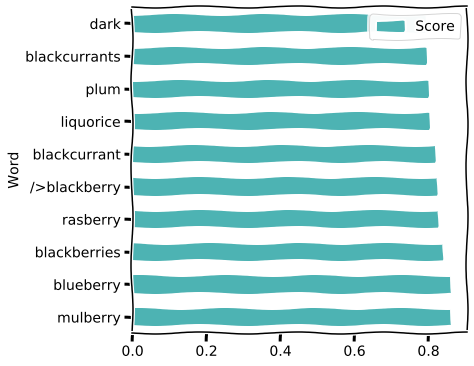

In [145]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("blackberry", topn=10, restrict_vocab=10000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

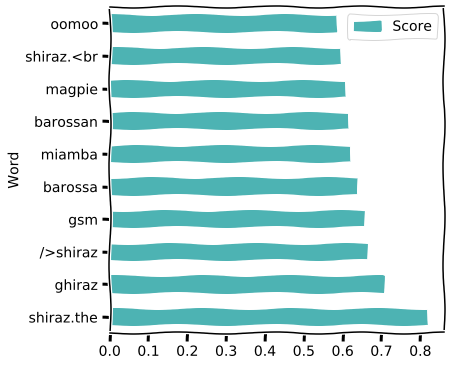

In [146]:
with plt.xkcd():
  pd.DataFrame(ft_model.wv.most_similar("shiraz", topn=10, restrict_vocab=10000),columns=['Word','Score']).plot.barh(x='Word',figsize=(6,6),color=(0.3,0.7,0.7))

## Creating BM25 document vectors

In [147]:
import math
bm25 = BM25Okapi(tok_text)
weighted_doc_vects = []

for i,doc in tqdm(enumerate(tok_text)):
  doc_vector = []
  for word in doc:
    vector = ft_model[word]
    weight = (bm25.idf[word] * ((bm25.k1 + 1.0)*bm25.doc_freqs[i][word])) 
    / 
    (bm25.k1 * (1.0 - bm25.b + bm25.b *(bm25.doc_len[i]/bm25.avgdl))+bm25.doc_freqs[i][word])
    weighted_vector = vector * weight
    doc_vector.append(weighted_vector)
  doc_vector_mean = np.mean(doc_vector,axis=0)
  weighted_doc_vects.append(doc_vector_mean)

0it [00:00, ?it/s]/home/stu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
14459it [00:09, 1639.20it/s]/home/stu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/stu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
21821it [00:13, 1591.65it/s]


In [46]:
pickle.dump( weighted_doc_vects, open( "weighted_doc_vects.p", "wb" ) )

## Load document vectors, build index and search:

In [71]:
#weighted_doc_vects.pop(2428) # No idea whats wrong with this one. Lets drop for now.

nan

In [149]:
weighted_doc_vects.pop(14784)

nan

In [150]:
#with open( "weighted_doc_vects.p", "rb" ) as f:
#  weighted_doc_vects = pickle.load(f)
# create a random matrix to index
data = np.vstack(weighted_doc_vects)

# initialize a new index, using a HNSW index on Cosine Similarity - can take a couple of mins
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

In [160]:
# querying the index:
input = 'This Secret Selection Shiraz is sourced from a vineyard above sea level in Eden Valley region. The low-yielding crops produced wines that had rich aromas of ripe plums, black fruits and wild cherry with hints of warm spices and vanilla oak. A beautifully balanced wine with a length finish.'.lower().split()
#input = testing

query = [ft_model[vec] for vec in input]
query = np.mean(query,axis=0)

t0 = time.time()
ids, distances = index.knnQuery(query, k=5)
t1 = time.time()
print(f'Searched {df.shape[0]} records in {round(t1-t0,4) } seconds \n')
for i,j in zip(ids,distances):
  print(round(j,2))
  print(df.text.values[i])

Searched 21821 records in 0.0005 seconds 

0.03
Sourced from a single vineyard site in the Strathbogie Ranges, ideally suited to growing aromatic and balanced Pinot Gris. The cool nights here allow the fruit to reach optimum ripeness whilst retaining an elegant balance between flavour, alcohol and acidity. This wine by Pacha Mama underwent lees stirring while in barrel, resulting in a buttery richness and complexity that sets the pinot gris style apart from the tighter, more acidic Pinot Grigio. Rich and inviting nose with white musk, fresh qSourced from a single vineyard site in the Strathbogie Ranges, ideally suited to growing aromatic and balanced Pinot Gris. The cool nights here allow the fruit to reach optimum ripeness whilst retaining an elegant balance between flavour, alcohol and acidity. This wine by Pacha Mama underwent lees stirring while in barrel, resulting in a buttery richness and complexity that sets the pinot gris style apart from the tighter, more acidic Pinot Grigio.

/home/stu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [136]:
testing

'This delicious Pinot Noir from the Giesen winery is a lighter red with plenty of complex flavour. Rich blackberry forms the base of this wine, with hints of spice and oak adding depth. Crack open yours straight away, or leave it to rest and mature.'

In [14]:
df[df["text"] == "A generous wine full of rich, ripe of bramble fruits, dark plum, peppery spice and savoury nuances. The palate is supported by well-integrated tannins providing structure and a long, fine finish."]

,index,Unnamed: 0,RecommendedProducts,ProductsInSameOffer,Categories,BackorderMessage,Reviews,DeliveryOptionsInfo,SavedLists,Stockcode,...,webtotalreviewcount,webvideourl,webvintagecurrent,webvintagenote,webwhiskystyle,webwinebody,webwinemaker,webwinestyle,Mystery,text


In [15]:
df["Stockcode"]

0       130687
1       132881
2       830650
3        86072
4        11021
         ...  
6245    916397
6246    916586
6247    742551
6248    900067
6249      9504
Name: Stockcode, Length: 6250, dtype: object

In [19]:
df[df["Stockcode"]=="76525"]

,index,Unnamed: 0,RecommendedProducts,ProductsInSameOffer,Categories,BackorderMessage,Reviews,DeliveryOptionsInfo,SavedLists,Stockcode,...,webtotalreviewcount,webvideourl,webvintagecurrent,webvintagenote,webwhiskystyle,webwinebody,webwinemaker,webwinestyle,Mystery,text


## Fuzzy matching

In [84]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def fuzzy_merge(df_1, df_2, key1, key2, threshold=95, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    #m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    #df_1['matches'] = m2
    
    return df_1

In [86]:
fuzzy_merge(df1, df2, 'webdescriptionshort', 'webdescriptionshort', threshold=80)

KeyboardInterrupt: 

In [83]:
s = df_2[key2].tolist()

NameError: name 'df_2' is not defined